In [1]:
import warnings
warnings.filterwarnings("ignore")

import read_data as imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import pyfolio

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def find_median(x):
    x = x[(x.T != 0).any()]
    aux = np.array([0.0 for k in range(x.shape[0])])
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            aux[i] += np.linalg.norm(x.iloc[i,]-x.iloc[j,])
    return x.iloc[np.where(aux == aux.min())[0][0],:]

In [3]:
base = 252

symbols = pd.read_csv('Nemos.csv')['Nemo'].tolist()
years = [x for x in range(2013,2019)]
hist_data = imp.organizarTodo(symbols,years)

Daily_Assets = pd.DataFrame()
for asset,df in hist_data.items():
    Daily_Assets[asset] = df['Close']
    
Daily_Log_Assets = Daily_Assets.pct_change()

In [4]:
Initial_Date = pd.to_datetime('2014-01-01')

Rebalancing_dates = [Initial_Date]
curr_month = Initial_Date.month

the_start = np.where(Initial_Date == Daily_Assets.index)[0].tolist()[0]

for i in range((the_start+1), len(Daily_Assets.index)):
    if Daily_Assets.index[i].month != curr_month:
        Rebalancing_dates.append(Daily_Assets.index[i-1])
        curr_month = Daily_Assets.index[i].month

com = 0.0015
BidAskSpread = 0.00016

In [5]:
Markowitz_Returns = pd.DataFrame(index = Daily_Assets.index[Daily_Assets.index >= Initial_Date],
                                 columns = ['Clasico', 'Mediana', 'Mediana Indicadora', 'Indicadora Invertida'],
                                 dtype = 'float')

Curr_Wi = np.zeros(len(Daily_Assets.columns))
RCurr_Wi = np.zeros(len(Daily_Assets.columns))
R2Curr_Wi = np.zeros(len(Daily_Assets.columns))
R3Curr_Wi = np.zeros(len(Daily_Assets.columns))

WC = pd.DataFrame(index=Daily_Assets.index[Daily_Assets.index >= Initial_Date], columns= Daily_Assets.columns)
WR = pd.DataFrame(index=Daily_Assets.index[Daily_Assets.index >= Initial_Date], columns= Daily_Assets.columns)
WR2 = pd.DataFrame(index=Daily_Assets.index[Daily_Assets.index >= Initial_Date], columns= Daily_Assets.columns)
WR3 = pd.DataFrame(index=Daily_Assets.index[Daily_Assets.index >= Initial_Date], columns= Daily_Assets.columns)

Memory_time_window = base

for i in Daily_Assets.index[Daily_Assets.index >= Initial_Date]:
            
    if i in Rebalancing_dates:
        
        end = np.where(i == Daily_Assets.index)[0].tolist()[0]
        ini = end - Memory_time_window
        
        dfaux = Daily_Assets.iloc[ini:end,:].pct_change().dropna(how="all").copy()
        
        # Classic
        mu = base * dfaux.mean()
        S = base * dfaux.cov()

        ef = EfficientFrontier(mu, S)#, weight_bounds=(-1, 1))
        ef.max_sharpe()
        Curr_Wi = np.array([x for y,x in ef.clean_weights().items()])
        
        # Margin Median
        mu = base * dfaux.median()
        LW_Cov = LedoitWolf().fit(dfaux).covariance_
        S = base * LW_Cov

        ef = EfficientFrontier(mu, S)#, weight_bounds=(-1, 1))
        ef.max_sharpe()
        RCurr_Wi = np.array([x for y,x in ef.clean_weights().items()])
        
        # Indicator Median
        mu = base * find_median(dfaux)
        LW_Cov = LedoitWolf().fit(dfaux).covariance_
        S = base * LW_Cov

        ef = EfficientFrontier(mu, S)#, weight_bounds=(-1, 1))
        ef.max_sharpe()
        R2Curr_Wi = np.array([x for y,x in ef.clean_weights().items()])
        
        R3Curr_Wi = -R2Curr_Wi.copy()
        
        # Saving Weights
        
        WC.loc[i,] = Curr_Wi
        WR.loc[i,] = RCurr_Wi
        WR2.loc[i,] = R2Curr_Wi
        WR3.loc[i,] = R3Curr_Wi
        
        Markowitz_Returns.loc[i, ['Clasico']] = np.dot(Daily_Log_Assets.loc[i,],Curr_Wi)*(1-com)*(1-BidAskSpread)
        Markowitz_Returns.loc[i, ['Mediana']] = np.dot(Daily_Log_Assets.loc[i,],RCurr_Wi)*(1-com)*(1-BidAskSpread)
        Markowitz_Returns.loc[i, ['Mediana Indicadora']] = np.dot(Daily_Log_Assets.loc[i,],R2Curr_Wi)*(1-com)*(1-BidAskSpread)
        Markowitz_Returns.loc[i, ['Indicadora Invertida']] = np.dot(Daily_Log_Assets.loc[i,],R3Curr_Wi)*(1-com)*(1-BidAskSpread)
    else:
        Markowitz_Returns.loc[i, ['Clasico']] = np.dot(Daily_Log_Assets.loc[i,],Curr_Wi)
        Markowitz_Returns.loc[i, ['Mediana']] = np.dot(Daily_Log_Assets.loc[i,],RCurr_Wi)
        Markowitz_Returns.loc[i, ['Mediana Indicadora']] = np.dot(Daily_Log_Assets.loc[i,],R2Curr_Wi)
        Markowitz_Returns.loc[i, ['Indicadora Invertida']] = np.dot(Daily_Log_Assets.loc[i,],R3Curr_Wi)

## Weights Behivor

In [6]:
# for asset in symbols:
#     plt.figure(figsize=(17,17))
#     plt.plot(WC[asset][100:150])
#     plt.plot(WR[asset][100:150])
#     plt.plot(WR2[asset][100:150])
#     plt.legend(['Classic', 'Robust', 'Robust2'])
#     plt.show()

## Comparison

In [7]:
Markowitz_Returns.to_excel('Resultados portafolios Long Only.xlsx')
WC.to_excel('Historico Pesos Clasico Long Only.xlsx')
WR.to_excel('Historico Pesos Mediana Long Only.xlsx')
WR2.to_excel('Historico Pesos Indicadora Long Only.xlsx')
WR3.to_excel('Historico Pesos Indicadora Inversa Long Only.xlsx') 

In [20]:
Markowitz_Returns.columns

Index(['Clasico', 'Mediana', 'Mediana Indicadora', 'Indicadora Invertida'], dtype='object')

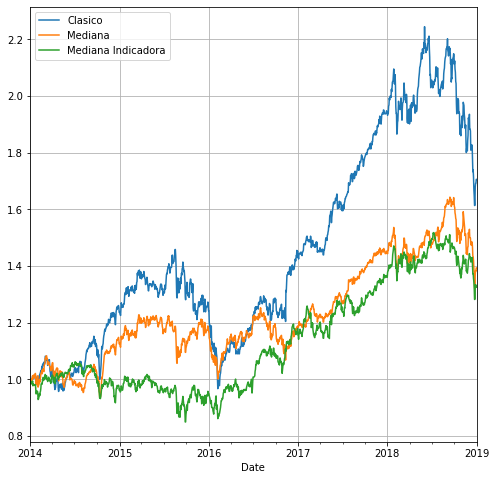

In [26]:
juntas = Markowitz_Returns.drop('Indicadora Invertida', axis = 1)
juntas = (juntas + 1).cumprod()
juntas.plot(figsize=(8,8) , grid = True)

Start date,2014-01-01
End date,2019-01-01
Total months,62
,Backtest
Annual return,6.6%
Cumulative returns,39.4%
Annual volatility,14.7%
Sharpe ratio,0.51
Calmar ratio,0.34
Stability,0.83
Max drawdown,-19.5%


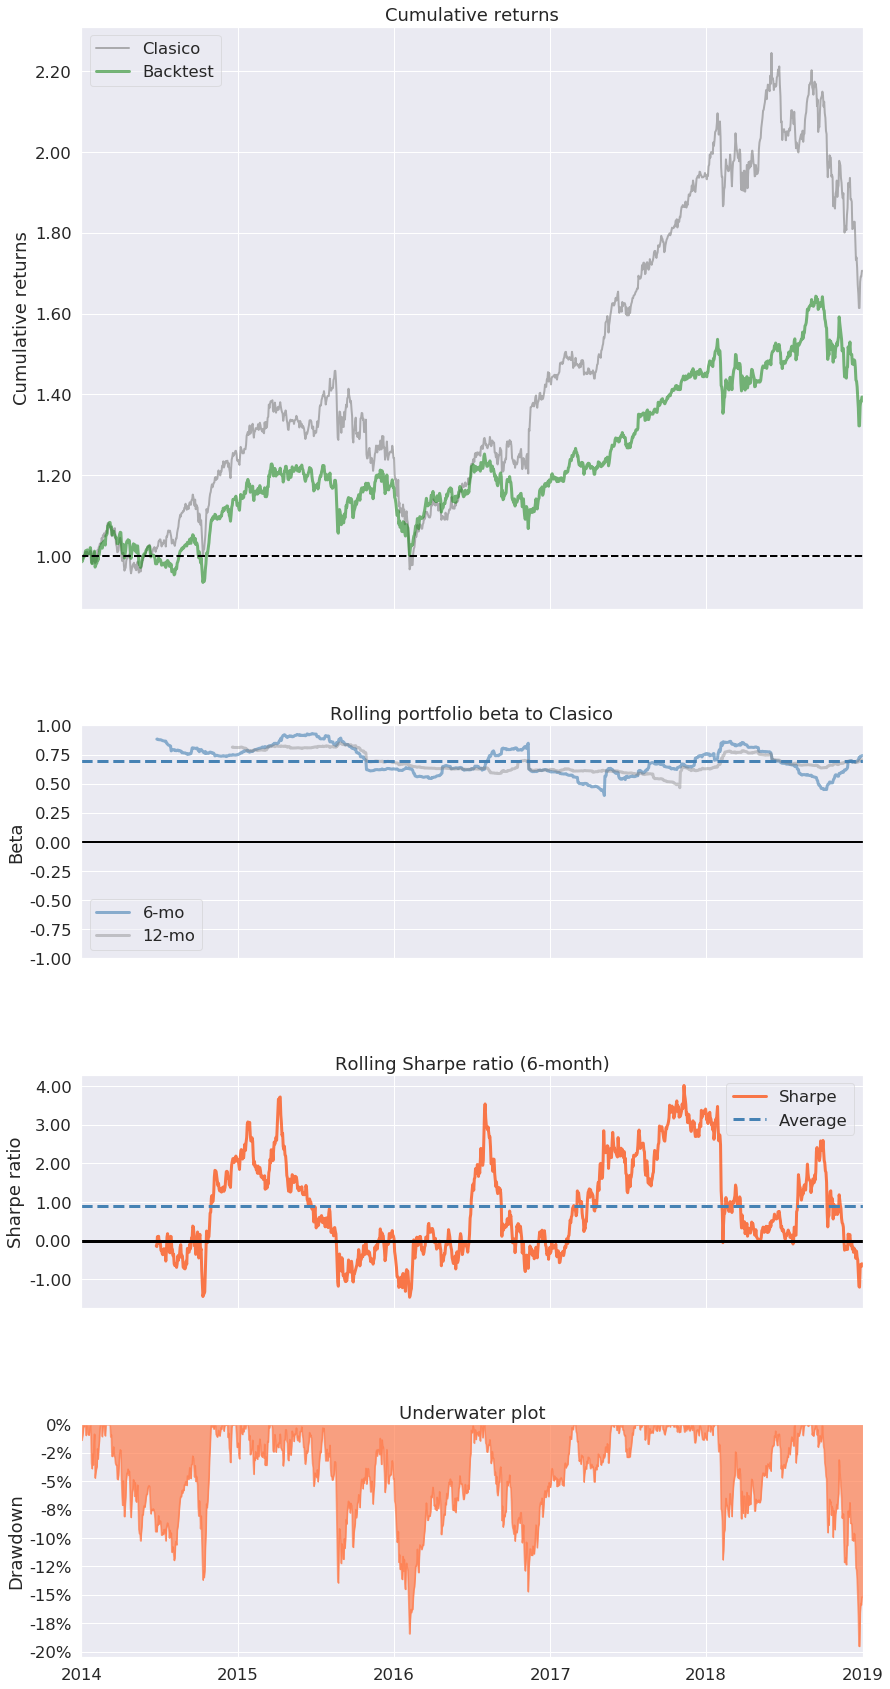

In [12]:
pyfolio.create_simple_tear_sheet(Markowitz_Returns['Mediana'], benchmark_rets=Markowitz_Returns['Clasico'])

Start date,2014-01-01
End date,2019-01-01
Total months,62
,Backtest
Annual return,5.6%
Cumulative returns,32.5%
Annual volatility,15.1%
Sharpe ratio,0.44
Calmar ratio,0.28
Stability,0.74
Max drawdown,-20.0%


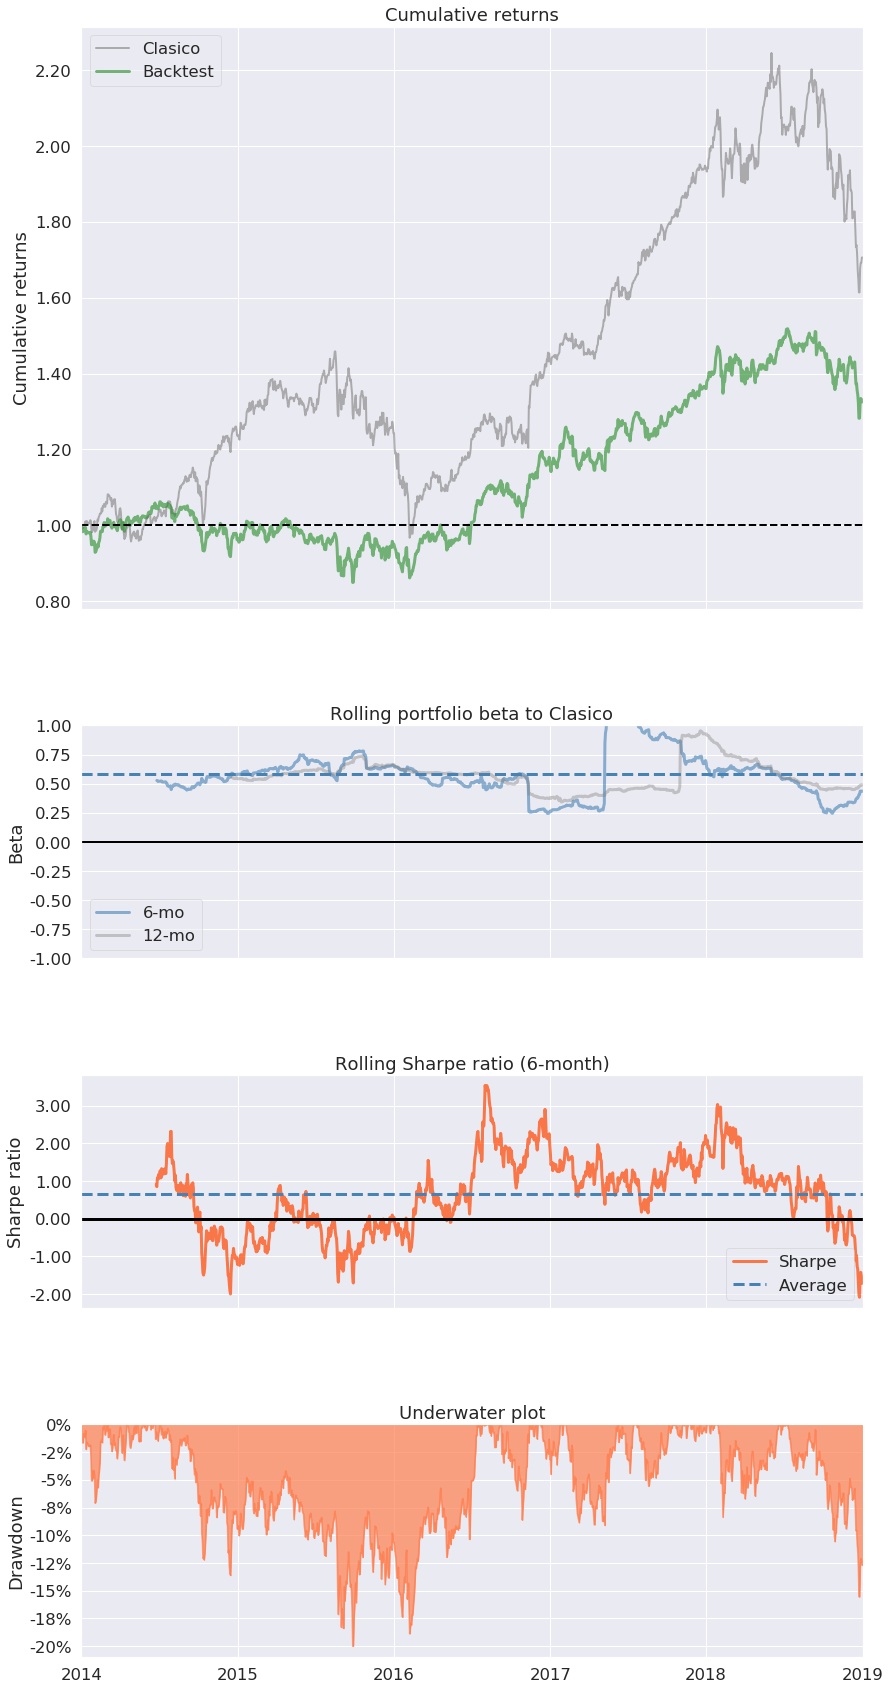

In [13]:
pyfolio.create_simple_tear_sheet(Markowitz_Returns['Mediana Indicadora'], benchmark_rets=Markowitz_Returns['Clasico'])

Start date,2014-01-01
End date,2019-01-01
Total months,62
,Backtest
Annual return,-7.4%
Cumulative returns,-33.0%
Annual volatility,15.1%
Sharpe ratio,-0.44
Calmar ratio,-0.16
Stability,0.83
Max drawdown,-47.7%


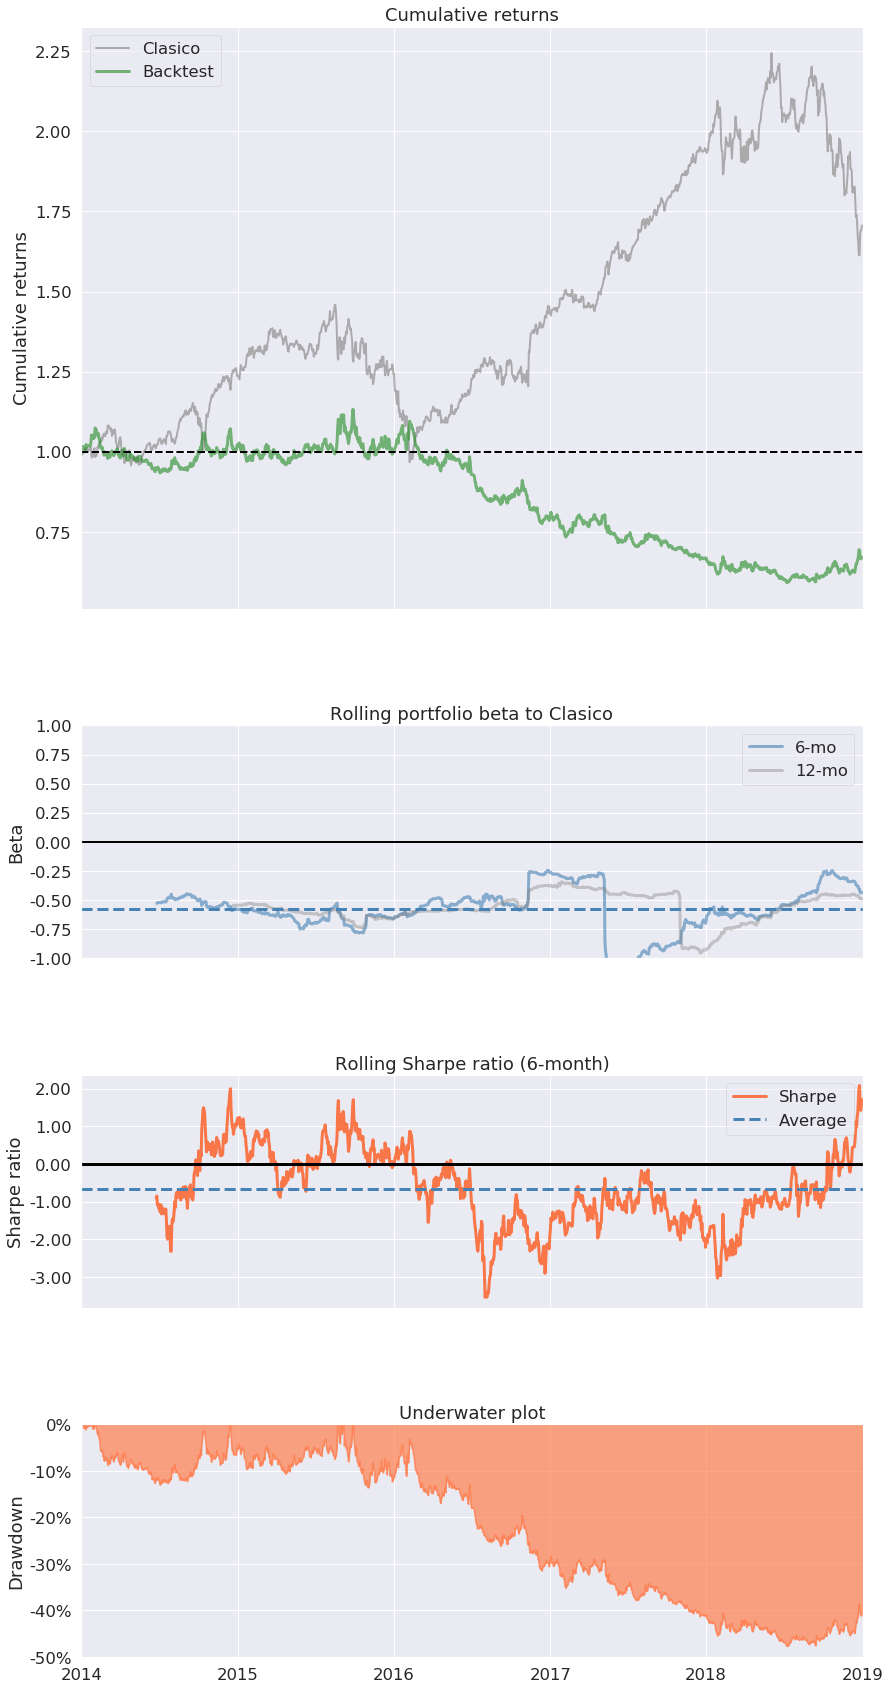

In [14]:
pyfolio.create_simple_tear_sheet(Markowitz_Returns['Indicadora Invertida'], benchmark_rets=Markowitz_Returns['Clasico'])

Start date,2014-01-01
End date,2019-01-01
Total months,62
,Backtest
Annual return,10.9%
Cumulative returns,70.6%
Annual volatility,17.9%
Sharpe ratio,0.67
Calmar ratio,0.32
Stability,0.80
Max drawdown,-33.7%


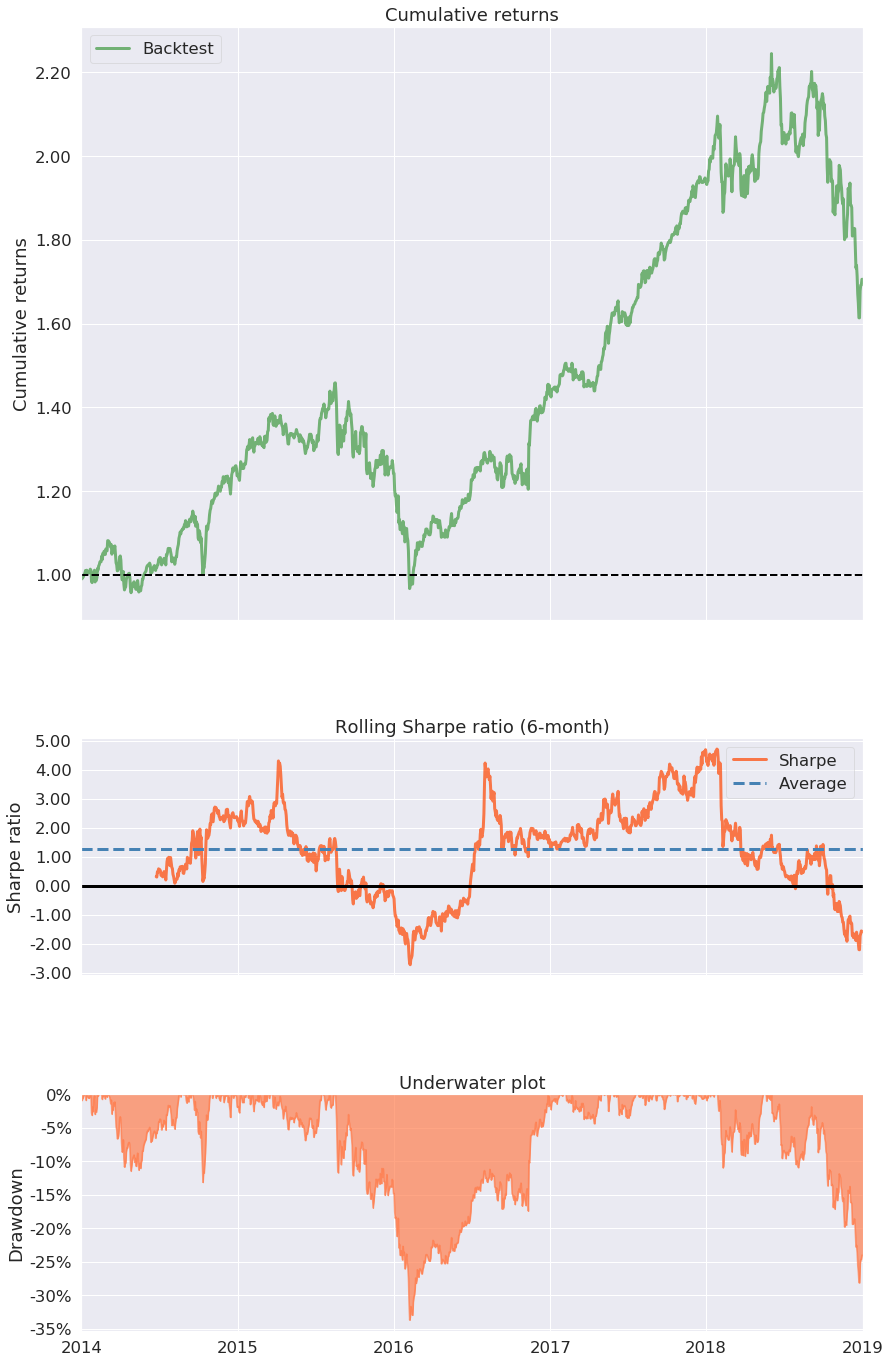

In [15]:
pyfolio.create_simple_tear_sheet(Markowitz_Returns['Clasico'])